In [1]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [2]:
beta0 = 5
beta1 = 3.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=-2,scale=1,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([628]))


In [3]:
np.random.seed()
yn,xn,nobs = gen_data()

In [4]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args, error_distr=stats.norm, **kwargs):
        self.error_distr = error_distr
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        
        #print(self.error_distr)
        #print(error_distr)
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = self.error_distr.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        pr_m = self.error_distr.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        ll =  (1-m)*pr_y + m*pr_m
        return ll
    
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        b = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        s =  np.sqrt(sigma2)

        beta_jac = np.zeros(len(b))
        sigma_jac = 0
        
        #for censored
        left_stats = (y - np.dot(x, b)) / s
        l_pdf = scipy.stats.norm.logpdf(left_stats)
        l_cdf = scipy.stats.norm.logcdf(left_stats)
        left_frac = np.exp(l_pdf - l_cdf)
        beta_left = np.dot(left_frac*m, x*m_x / s)
        beta_jac -= beta_left
        left_sigma = np.dot(left_frac*m, left_stats*m)
        sigma_jac -= left_sigma
        
        #for non-censored
        mid_stats = (y - np.dot(x, b)) / s
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) / s)
        beta_jac += beta_mid
        mid_sigma = ((np.square(mid_stats) - 1)*(1-m)).sum()
        sigma_jac += mid_sigma
        
        combo_jac = np.append(beta_jac, sigma_jac / (2*s) )  # by chain rule, since the expression above is dloglik/dlogsigma
        return combo_jac

model1 =  Tobit(yn,sm.add_constant(xn))
print(model1.score(np.array([beta0,beta1,1])))
#model1_fit = model1.fit(disp=False)
#model1_fit.summary()

[-4.82709365 -7.89285453  5.95204862]


In [5]:
print(stats.logistic)

model2 =  Tobit(yn,sm.add_constant(xn),error_distr=stats.logistic)
model2_fit = model2.fit(disp=False)
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Tobit Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -642.12
Model:                          Tobit   AIC:                             1288.
Method:            Maximum Likelihood   BIC:                             1298.
Date:                Tue, 01 Dec 2020                                         
Time:                        15:55:56                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9102      0.101     48.623      0.000       4.712       5.108
x1             2.9423      0.075     39.286      0.000       2.795       3.089
var            0.3275      0.028     11.810      0.000       0.273       0.382
==============================================================================
"""

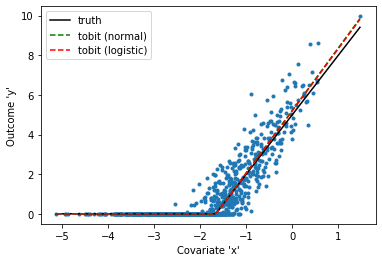

In [29]:
#create plot for true
plt.scatter(xn,yn,marker='.')
support_x = np.arange(xn.min(),xn.max(),.05)

#truth
plt.plot(support_x, np.maximum(beta0+beta1*support_x,0) ,label="truth",
         color='black')

#tobit
plt.plot(support_x, np.maximum(0,model1_fit.params[0] + model1_fit.params[1]*support_x) ,label="tobit (normal)",
         color='green',linestyle='--')

#ols
plt.plot(support_x, np.maximum(0,model2_fit.params[0] + model2_fit.params[1]*support_x) ,label="tobit (logistic)",
         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome 'y'")
plt.xlabel("Covariate 'x'")
plt.savefig('../figs/tobit_plot2.png')
plt.legend()
plt.show()


In [30]:
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).mean() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).min() )

0.0018495796002306261
0.008420356083645894
0.23555975854760858
-1.6977052708182478
